In [2]:
import torch
import torch.nn.functional as F

import numpy as np
from PIL import Image

from tokenizer.tokenizer_image.vq_model import VQ_models
from dataset.augmentation import center_crop_arr

In [2]:
torch.cuda.is_available()

True

In [3]:
image_path = "assets/newyork.jpg"
output_dir = "output_vq_demo" #don't need this for visualization
suffix = "tokenizer_image" 
vq_model = "VQ-16" # 16*16 tokens
vq_ckpt = "pretrained_models/vq_ds16_c2i.pt" # pretrained VQVAE Model
codebook_size = 16384
codebook_embed_dim = 8
image_size = 512
seed = 0


In [4]:
torch.manual_seed(0) #Set seed
torch.set_grad_enabled(False) #no grads needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQ_models[vq_model](codebook_size = codebook_size
                            , codebook_embed_dim = codebook_embed_dim).to(device)
model.to(device)
model.eval()

checkpoint = torch.load(vq_ckpt, map_location=device)
if "ema" in checkpoint:  # ema
    model_weight = checkpoint["ema"]
elif "model" in checkpoint:  # ddp
    model_weight = checkpoint["model"]
elif "state_dict" in checkpoint:
    model_weight = checkpoint["state_dict"]
else:
    raise Exception("please check model weight")
model.load_state_dict(model_weight)
del checkpoint


pil_image = Image.open(image_path).convert("RGB")
img = center_crop_arr(pil_image, image_size) #size에 맞게 변형

img = np.array(img)/255.0

x = 2.0 * img - 1.0 #x is value between -1 and 1
x = torch.tensor(x)
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)
x_input = x.float().to("cuda")


# inference
with torch.no_grad():
    latent, _, [_, _, indices] = model.encode(x_input)
    output = model.decode_code(indices, latent.shape) # output value is between [-1, 1]

# postprocess
output = F.interpolate(output, size=[image_size, image_size], mode='bicubic').permute(0, 2, 3, 1)[0]
sample = torch.clamp(127.5 * output + 128.0, 0, 255).to("cpu", dtype=torch.uint8).numpy()


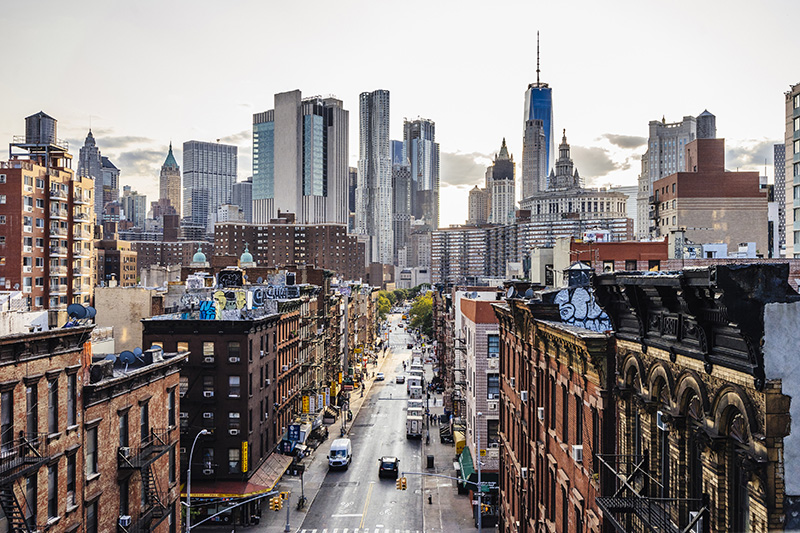

In [5]:
Image.open(image_path).convert("RGB")

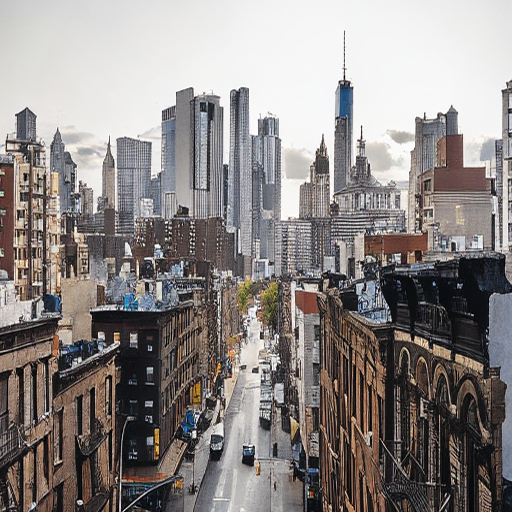

In [6]:
sample_image = Image.fromarray(sample)

display(sample_image)

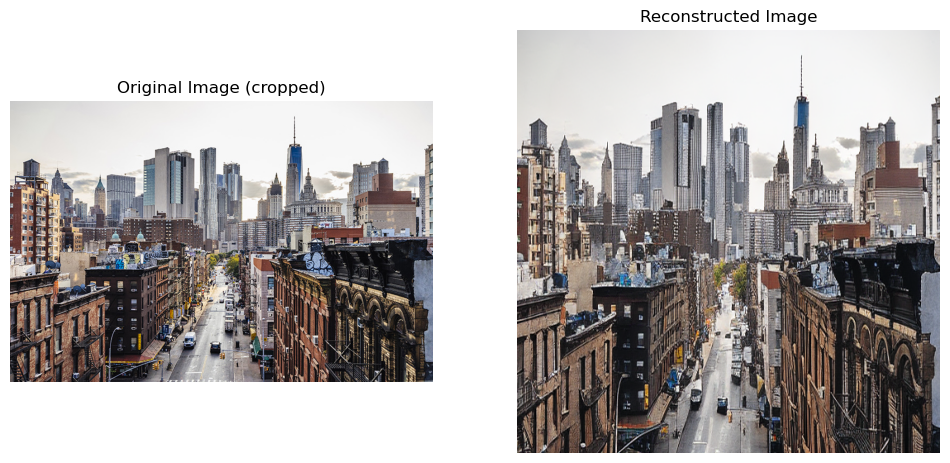

In [8]:
import matplotlib.pyplot as plt

original_image = Image.open(image_path).convert("RGB")
img = center_crop_arr(pil_image, image_size) #size에 맞게 변형
sample_image = Image.fromarray(sample)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axs[0].imshow(img)
axs[0].set_title("Original Image (cropped)")
axs[0].axis('off')

# Display the reconstructed image
axs[1].imshow(sample_image)
axs[1].set_title("Reconstructed Image")
axs[1].axis('off')

plt.show()